In [1]:
import datasets
import torch
import torch.nn as nn
import numpy as np
import random
from typing import final
from razdel import tokenize
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from IPython import display as ipython_display
from typing import TypedDict
from collections.abc import Iterable

# Обработка датасета

In [2]:
MAX_VOCAB = 50000

news_dataset = datasets.load_dataset("data-silence/rus_news_classifier")
categories_translator = {
    'climate': 0,
    'conflicts': 1,
    'culture': 2,
    'economy': 3,
    'gloss': 4,
    'health': 5,
    'politics': 6,
    'science': 7,
    'society': 8,
    'sports': 9,
    'travel': 10
}
id2label = {v: k for k, v in categories_translator.items()}


train_texts: list[str] = list(news_dataset["train"]["news"])
train_labels: list[int] = list(news_dataset["train"]["labels"])

val_texts: list[str] = list(news_dataset["test"]["news"])
val_labels: list[int] = list(news_dataset["test"]["labels"])

num_classes = len(set(train_labels))

counter: Counter[str] = Counter()
for text in train_texts:
    for token in tokenize(text.lower()):
        counter[token.text] += 1

vocab = [w for w, _ in counter.most_common(MAX_VOCAB)]
word_to_idx = {w: i for i, w in enumerate(vocab)}

PAD_IDX = len(vocab) - 2
UNK_IDX = len(vocab) - 1
vocab_size = len(vocab)

In [3]:
from torch.nn.utils.rnn import pad_sequence

@final
class NewsDataset(Dataset[tuple[torch.Tensor, torch.Tensor]]):
    def __init__(self, texts: list[str], labels: list[int], max_len: int = 100):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx) -> tuple[torch.Tensor, torch.Tensor]:
        tokens = self.texts[idx].lower().split()
        ids = [word_to_idx.get(t, UNK_IDX) for t in tokens]
        if len(ids) > self.max_len:
            ids = ids[: self.max_len]
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return torch.tensor(ids, dtype=torch.long), y

def collate_fn(batch):
    sequences, labels = zip(*batch)

    x = pad_sequence(sequences, batch_first=True, padding_value=PAD_IDX)

    y = torch.stack(labels)
    return x, y

In [4]:
BATCH_SIZE = 32
MAX_LEN = 200

train_ds = NewsDataset(train_texts, train_labels, MAX_LEN)
val_ds = NewsDataset(val_texts, val_labels, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Создание и инициализация модели

In [ ]:
@final
class TextCNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, word2idx: dict[str, int], num_classes: int, kernel_sizes: list[int] = [3,4,5], num_filters: int = 100):
        super().__init__()

        self.embedding = self.__generate_embedding(word2idx, embedding_dim)
        self.embedding_dropout = nn.Dropout(0.2)

        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=k),
                nn.BatchNorm1d(num_filters),
                nn.ReLU()
            )
            for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def __generate_embedding(self, word2idx: dict[str, int], embedding_dim: int) -> nn.Embedding:
        vocab_size = len(word2idx)
        
        weights = np.random.normal(scale=0.6, size=(vocab_size, embedding_dim)).astype(np.float32)
        weights[PAD_IDX] = np.zeros(embedding_dim, dtype=np.float32)
        weights[UNK_IDX] = np.mean(weights, axis=0)
        
        return nn.Embedding.from_pretrained(torch.tensor(weights), freeze=False, padding_idx=PAD_IDX)

    def forward(self, x):
            # [batch, seq_len]
            x = self.embedding(x.long())  # [batch, seq_len, embed_dim]
            x = self.embedding_dropout(x)

            x = x.permute(0, 2, 1)  # [batch, embed_dim, seq_len] for conv
            x_convs = [conv(x) for conv in self.convs]  # len(kernel_sizes) * [batch, num_filters, seq_len - kernel_size + 1]
            feature_maxes = [torch.max(feat, dim=2)[0] for feat in x_convs]  # len(kernel_sizes) [batch, num_filters]
            x = torch.cat(feature_maxes, dim=1)  # [batch, num_filters * len(kernel_sizes)]
            x = self.dropout(x)
            logits = self.fc(x)
            return logits

@final
class EarlyStopping:
    def __init__(self, patience=3, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float("inf")
        self.counter = 0
        self.stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.stop = True

In [6]:
class Metrics(TypedDict):
    loss: list[float]
    accuracy: list[float]

class History(TypedDict):
    train: Metrics
    test: Metrics

def plot(history: History) -> None:
    metrics: Iterable[str] = history["train"].keys()

    num_metrics = len(list(metrics))
    cols = 2 if num_metrics > 1 else 1
    rows = (num_metrics + 1) // 2

    plt.figure(figsize=(6 * cols, 4 * rows))

    for idx, metric in enumerate(metrics):
        plt.subplot(rows, cols, idx + 1)

        # Две линии: train и test
        for phase in ("train", "test"):
            plt.plot(
                history[phase][metric],
                label=phase,
                linewidth=2,
                marker='o'
            )

        plt.title(metric.capitalize(), fontsize=14)
        plt.xlabel("Epoch", fontsize=12)
        plt.ylabel(metric.capitalize(), fontsize=12)
        plt.grid(alpha=0.3, linestyle='--')
        plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

In [22]:
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TextCNN(vocab_size, 300, word_to_idx, num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)
early_stoping = EarlyStopping(patience=2, delta=0.02)

history: History = {"train": {"loss": [], "accuracy": []}, "test": {"loss": [], "accuracy": []}}

from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
TextCNN                                  --
├─Embedding: 1-1                         15,000,000
├─Dropout: 1-2                           --
├─ModuleList: 1-3                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv1d: 3-1                  90,100
│    │    └─BatchNorm1d: 3-2             200
│    │    └─ReLU: 3-3                    --
│    └─Sequential: 2-2                   --
│    │    └─Conv1d: 3-4                  120,100
│    │    └─BatchNorm1d: 3-5             200
│    │    └─ReLU: 3-6                    --
│    └─Sequential: 2-3                   --
│    │    └─Conv1d: 3-7                  150,100
│    │    └─BatchNorm1d: 3-8             200
│    │    └─ReLU: 3-9                    --
├─Dropout: 1-4                           --
├─Linear: 1-5                            3,311
Total params: 15,364,211
Trainable params: 15,364,211
Non-trainable params: 0

# Тренировка модели

In [20]:
def train_step(model: nn.Module, train_loader: DataLoader, epoch: int):
    model.train()

    total_loss = 0
    correct = 0
    for x, y in tqdm(train_loader, desc=f"Train epoch {epoch+1}"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)

        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()

        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader), correct / len(train_loader.dataset)

def test_step(model: nn.Module, test_loader: DataLoader, epoch: int):
    total_loss = 0
    correct = 0

    model.eval()
    with torch.no_grad():
        for x, y in tqdm(test_loader, desc=f"Val epoch {epoch+1}"):
            x, y = x.to(device), y.to(device)
            logits = model(x)

            pred = logits.argmax(dim=1)

            correct += (pred == y).sum().item()
            loss = loss_fn(logits, y)
            total_loss += loss.item()

    return total_loss / len(test_loader), correct / len(test_loader.dataset)

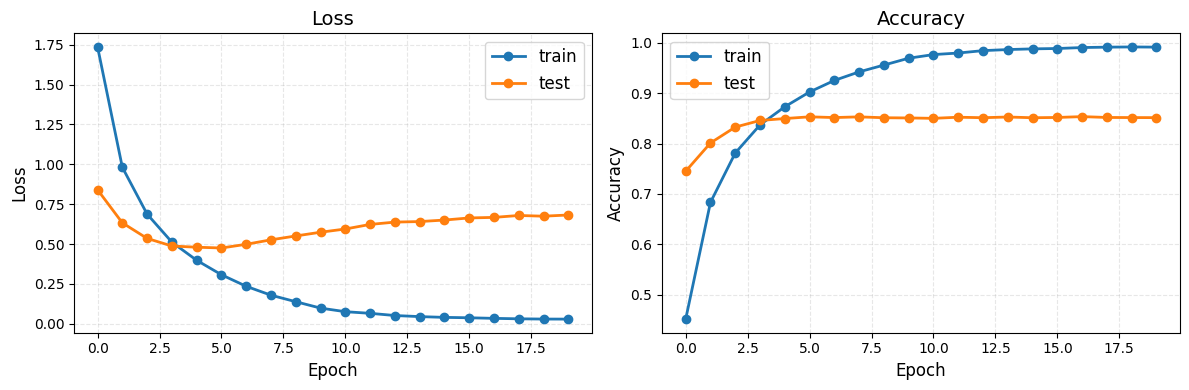

In [ ]:
max_test_loss = 0
for epoch in range(20):
    train_loss, train_accuracy = train_step(model, train_loader, epoch)
    history["train"]["loss"].append(train_loss)
    history["train"]["accuracy"].append(train_accuracy)

    test_loss, test_accuracy = test_step(model, test_loader, epoch)
    history["test"]["loss"].append(test_loss)
    history["test"]["accuracy"].append(test_accuracy)

    sheduler.step(test_loss)

    ipython_display.clear_output()
    plot(history)

    if test_loss > max_test_loss:
        max_test_loss = test_loss
        torch.save(model.state_dict(), "best_text_cnn_emb300.pt")

    if early_stoping.stop:
        break

In [13]:
torch.save(model.state_dict(), "text_cnn_model_emb300.pt")

# Примеры инференса

In [ ]:
model = TextCNN(vocab_size, 300, word_to_idx, num_classes).to(device)
model.load_state_dict(torch.load("best_cnn_model_emb300.pt"))

<All keys matched successfully>

In [24]:
def texts_to_batch(texts: list[str], word2idx: dict[str, int], max_len: int = MAX_LEN) -> torch.Tensor:
    ids_list = []
    for t in texts:
        tokens = t.lower().split()
        ids = [word2idx.get(tok, UNK_IDX) for tok in tokens][:max_len]
        if len(ids) == 0:
            ids = [PAD_IDX]
        ids_list.append(torch.tensor(ids, dtype=torch.long))

    x = pad_sequence(ids_list, batch_first=True, padding_value=PAD_IDX)
    return x

In [29]:
model.eval()


random_ids = [random.randint(0, len(val_texts)-1) for _ in range(4)]
examples = [val_texts[i] for i in random_ids]
answers = [val_labels[i] for i in random_ids]


x = texts_to_batch(examples, word_to_idx)
x = x.to(device)

with torch.no_grad():
    logits = model(x)
    probs = torch.softmax(logits, dim=1)
    preds = probs.argmax(dim=1).cpu().tolist()

for text, prob_vec, true in zip(examples, probs.cpu().numpy(), answers):
    topk = 3
    topk_idx = sorted(range(len(prob_vec)), key=lambda i: prob_vec[i], reverse=True)[:topk]
    topk_str = ", ".join(f"{id2label[i]}: {prob_vec[i]:.3f}" for i in topk_idx)

    print("Text:", text)
    print("Correct label:", id2label[true])
    print("Top 3 predicts:", topk_str)
    print()


Text: Популярный блогер, делящийся советами для бизнесменов в TikTok, раскрыл способ избежать штрафа при отмене брони в отеле. О лайфхаке он рассказал на видео в TikTok. В ролике Мо Ельхаммади (Mo Elhammady) разыгрывает ситуацию, притворяясь, что звонит в гостиницу, чтобы отменить бронь меньше чем за 24 часа до заезда. Когда менеджер сообщает путешественнику, что ему придется заплатить штраф в 200 долларов (почти 17 тысяч рублей), Ельхаммади возмущается и затем просит перенести бронирование на неделю. После этого, по словам блогера, можно позвонить в гостиницу на следующий день и снова запросить отмену бронирования. Таким образом, постояльцу не придется платить штраф, поскольку отмена произойдет за неделю до въезда. «Отели не хотят, чтобы вы знали об этом лайфхаке», — подписал публикацию Ельхаммади. Мнения пользователей сети под видео разделились. «Это реально работает, я делаю так уже 10 лет. Но если об этом рассказывать всем подряд, отели перестанут идти на уступки», «Очень полезный 